In [1]:
from pathlib import Path
from tkinter import Tk
from tkinter.filedialog import askopenfilenames
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.ticker as plticker

idx = pd.IndexSlice

# Define automatic naming format from file_paths
def get_name(file_path,data_type):
    name = file_path.stem.split("_")
    if data_type == 'avg':
        name = name[3]+'_'+name[4]
    elif data_type == 'indv':
        name = name[3]+'_'+name[5]
        
    return name

# Define axis labels based on parameter
def gen_param_label(param):
    param_dict = {
        'mAh':'[mAh]',
        'mass':'[mAh/g]',
        'areal':r'$\mathrm{[mAh/cm^2]}$',
        'volume':r'$\mathrm{[mAh/cm^3]$'}
    
    return param_dict[param]

In [2]:
# Open file dialog
root = Tk()
root.attributes("-topmost", True)
root.withdraw()  # stops root window from appearing
file_paths = askopenfilenames(title="Select files",
                              filetypes=[("Comma-separated values", "*.csv")])  # "Open" dialog box and return the selected path

# Convert filepaths to pathlib format
filez = []
for file in file_paths:
    file = Path(file)
    filez.append(file)
    
file_paths = filez

In [3]:
# Generate 'names' and 'param' dictionaries from file_paths
# read_csv to dataframe
names={}
params = {}
avg = []
df=[]
for i, file_path in enumerate(file_paths):   
    df_imp = pd.read_csv(file_paths[i],header=[1,2],index_col=[0,1])
    df_imp = pd.concat([df_imp], axis=1, keys=[i])
    
    df.append(df_imp)
    
    if 'avg' in file_paths[i].stem or len(df_imp.columns.values) > 2:
        data_type = 'avg'
        avg.append(True)
    else:
        data_type = 'indv'
        avg.append(False)
    
    name = get_name(file_paths[i],data_type)
    names[i] = name

    params[i] = df_imp.columns.get_level_values(1)[1]
            
df = pd.concat(df, axis=1)
df.sort_index(inplace=True)

for cell in names:
    print(cell, '->', names[cell], '->', params[cell], '-> Avg:', str(avg[cell]))

0 -> 201112_SL1 -> mass -> Avg: True


In [4]:
### Generate df for Energy Capacity ###

# Filters
posCC = [3,8]
posCV = [4,9]
negCC = [6,11]
cycles = range(1,len(posCC)+1)

# Create new dataframe
df_new = []
df_list = []

for cell in names:
    # Generate new df from posCC filter
    df_new = df.loc[idx[posCC,:],idx[cell,params[cell],:]].copy()
    df_new['cycle'] = list(cycles)
    df_new.reset_index()
    df_new.set_index('cycle',inplace=True)
    df_new.drop('cap_std', axis=1, level=2, inplace=True)
    df_new.columns.set_levels(['p_cap_CC'],level=2,inplace=True)
    
    # Create temp capacity arrays from posCV, posCC and negCC filters
    df_new2 = df.loc[idx[posCV,:],idx[cell,params[cell],'cap']].to_numpy()
    df_new3 = df.loc[idx[posCC,:],idx[cell,params[cell],'cap']].to_numpy()
    df_new4 = df.loc[idx[negCC,:],idx[cell,params[cell],'cap']].to_numpy()
    
    # Add temp capacity arrays as columns to df_new
    df_new[cell,params[cell],'p_cap_CV']=df_new2
    df_new[cell,params[cell],'p_cap_Tot']=df_new2+df_new3
    df_new[cell,params[cell],'n_cap_CC']=df_new4
    
    # If averaged data, do the same for std data
    if avg[cell]:
        df_new2 = df.loc[idx[posCV,:],idx[cell,params[cell],'cap_std']].to_numpy()
        df_new3 = df.loc[idx[posCC,:],idx[cell,params[cell],'cap_std']].to_numpy()
        df_new4 = df.loc[idx[negCC,:],idx[cell,params[cell],'cap_std']].to_numpy()
        
        df_new[cell,params[cell],'p_std_CC']=df_new3
        df_new[cell,params[cell],'p_std_CV']=df_new2
        df_new[cell,params[cell],'p_std_Tot']=df_new2+df_new3
        df_new[cell,params[cell],'n_std_CC']=df_new4
        
    df_list.append(df_new)
        
df_plot_energy = pd.concat(df_list, axis=1)
df_plot_energy

0                                                        \
             mass                                                         
         p_cap_CC  p_cap_CV   p_cap_Tot    n_cap_CC  p_std_CC  p_std_CV   
cycle                                                                     
1      160.616959  0.798777  161.415736  153.511374  3.229893  0.104466   
2      152.895408  0.800222  153.695629  153.535186  1.203101  0.130870   

                           
                           
      p_std_Tot  n_std_CC  
cycle                      
1      3.334359  1.285782  
2      1.333972  1.270822

In [5]:
### df for C-rate test ###

# Filters
posCC = [13,18,23,28,35,40,45]
posCV = [x+1 for x in posCC]
negCC = [x+3 for x in posCC]
cycles = range(1,len(posCC)+1)

# Create new dataframe
df_new = []
df_list = []

for cell in names:
    # Generate new df from posCC filter
    df_new = df.loc[idx[posCC,:],idx[cell,params[cell],:]].copy()
    df_new['cycle'] = list(cycles)
    df_new.reset_index()
    df_new.set_index('cycle',inplace=True)
    df_new.drop('cap_std', axis=1, level=2, inplace=True)
    df_new.columns.set_levels(['p_cap_CC'],level=2,inplace=True)
    
    # Create temp capacity arrays from posCV, posCC and negCC filters
    df_new2 = df.loc[idx[posCV,:],idx[cell,params[cell],'cap']].to_numpy()
    df_new3 = df.loc[idx[posCC,:],idx[cell,params[cell],'cap']].to_numpy()
    df_new4 = df.loc[idx[negCC,:],idx[cell,params[cell],'cap']].to_numpy()
    
    # Add temp capacity arrays as columns to df_new
    df_new[cell,params[cell],'p_cap_CV']=df_new2
    df_new[cell,params[cell],'p_cap_Tot']=df_new2+df_new3
    df_new[cell,params[cell],'n_cap_CC']=df_new4
    
    # If averaged data, do the same for std data
    if avg[cell]:
        df_new2 = df.loc[idx[posCV,:],idx[cell,params[cell],'cap_std']].to_numpy()
        df_new3 = df.loc[idx[posCC,:],idx[cell,params[cell],'cap_std']].to_numpy()
        df_new4 = df.loc[idx[negCC,:],idx[cell,params[cell],'cap_std']].to_numpy()
        
        df_new[cell,params[cell],'p_std_CC']=df_new3
        df_new[cell,params[cell],'p_std_CV']=df_new2
        df_new[cell,params[cell],'p_std_Tot']=df_new2+df_new3
        df_new[cell,params[cell],'n_std_CC']=df_new4
        
    df_list.append(df_new)

df_plot_rate = pd.concat(df_list, axis=1)
df_plot_rate

0                                                         \
             mass                                                          
         p_cap_CC   p_cap_CV   p_cap_Tot    n_cap_CC  p_std_CC  p_std_CV   
cycle                                                                      
1      151.319025   2.893298  154.212323  144.070417  0.977279  0.391798   
2      141.133156   2.998351  144.131507  138.274504  0.879647  0.372175   
3      135.428980   2.966507  138.395488  131.300665  1.185585  0.243878   
4      128.426002   3.032837  131.458839   87.466853  1.211615  0.257187   
5      142.498484   6.635363  149.133848  143.277979  0.989094  0.470972   
6      128.844149  13.467580  142.311729  142.064007  0.558246  1.122688   
7      111.070851  29.408697  140.479548  140.092110  1.512946  2.384985   

                           
                           
      p_std_Tot  n_std_CC  
cycle                      
1      1.369077  1.227707  
2      1.251823  1.411802  
3      1.429463  1.435980  
4      1.468802  1.142174  
5      1.460066  1.300954  
6      1.680933  1.306436  
7      3.897931  1.189698

In [6]:
### df for Degradation test ###

# Filters
init = 52
posCC = [init]
for i in range(1,22):
    if i == 10 or i == 21:
        posCC.append(posCC[i-1]+7)
    else:
        posCC.append(posCC[i-1]+5)

posCV = [x+1 for x in posCC]
negCC = [x+3 for x in posCC]
cycles = range(1,len(posCC)+1)

# Create new dataframe
df_new = []
df_list = []

for cell in names:
    # Generate new df from posCC filter
    df_new = df.loc[idx[posCC,:],idx[cell,params[cell],:]].copy()
    df_new['cycle'] = list(cycles)
    df_new.reset_index()
    df_new.set_index('cycle',inplace=True)
    df_new.drop('cap_std', axis=1, level=2, inplace=True)
    df_new.columns.set_levels(['p_cap_CC'],level=2,inplace=True)
    
    # Create temp capacity arrays from posCV, posCC and negCC filters
    df_new2 = df.loc[idx[posCV,:],idx[cell,params[cell],'cap']].to_numpy()
    df_new3 = df.loc[idx[posCC,:],idx[cell,params[cell],'cap']].to_numpy()
    df_new4 = df.loc[idx[negCC,:],idx[cell,params[cell],'cap']].to_numpy()
    
    # Add temp capacity arrays as columns to df_new
    df_new[cell,params[cell],'p_cap_CV']=df_new2
    df_new[cell,params[cell],'p_cap_Tot']=df_new2+df_new3
    df_new[cell,params[cell],'n_cap_CC']=df_new4
    
    # If averaged data, do the same for std data
    if avg[cell]:
        df_new2 = df.loc[idx[posCV,:],idx[cell,params[cell],'cap_std']].to_numpy()
        df_new3 = df.loc[idx[posCC,:],idx[cell,params[cell],'cap_std']].to_numpy()
        df_new4 = df.loc[idx[negCC,:],idx[cell,params[cell],'cap_std']].to_numpy()
        
        df_new[cell,params[cell],'p_std_CC']=df_new3
        df_new[cell,params[cell],'p_std_CV']=df_new2
        df_new[cell,params[cell],'p_std_Tot']=df_new2+df_new3
        df_new[cell,params[cell],'n_std_CC']=df_new4
        
    df_list.append(df_new)

df_plot_deg = pd.concat(df_list, axis=1)
df_plot_deg

0                                                         \
             mass                                                          
         p_cap_CC   p_cap_CV   p_cap_Tot    n_cap_CC  p_std_CC  p_std_CV   
cycle                                                                      
1      132.907261  14.869397  147.776658  137.586489  0.838952  1.195853   
2      122.330230  15.306418  137.636649  136.889885  0.823257  1.167314   
3      121.489681  15.427651  136.917332  136.791844  0.778577  1.088717   
4      121.513138  15.341312  136.854450  136.768918  0.800904  1.030970   
5      121.280922  15.576844  136.857766  136.479176  0.935816  0.925253   
6      120.737943  15.828644  136.566587  136.309973  1.098041  1.040034   
7      120.412917  15.978262  136.391179  136.135443  1.163690  0.725634   
8      120.257394  15.958892  136.216285  136.105798  0.921035  0.743004   
9      120.118360  16.087376  136.205736  136.267145  0.746889  0.911855   
10     120.116906  16.240142  136.357048  136.142713  1.172668  0.559830   
11     147.080337   0.951534  148.031871  152.731277  1.209184  0.035086   
12     136.954229  15.777926  152.732154  136.683626  0.991729  0.940533   
13     120.770080  15.992934  136.763014  136.714105  0.745907  0.826146   
14     120.333927  16.386729  136.720656  136.101569  0.774589  0.749876   
15     119.794504  16.288307  136.082810  135.569858  0.608000  1.012548   
16     119.100700  16.522243  135.622943  135.474078  1.017944  0.708310   
17     118.974672  16.565594  135.540266  135.437482  0.753182  0.717082   
18     118.815426  16.697225  135.512651  135.245621  0.927665  0.660555   
19     118.519459  16.827278  135.346738  135.454051  0.679435  0.736090   
20     118.513440  17.064539  135.577979  135.525408  0.646799  0.766322   
21     118.525000  17.084344  135.609344  135.020957  0.629770  0.862458   
22     146.503590   1.055957  147.559548  152.023005  1.270986  0.036967   

                           
                           
      p_std_Tot  n_std_CC  
cycle                      
1      2.034805  1.357694  
2      1.990571  1.516561  
3      1.867295  1.178303  
4      1.831874  1.573776  
5      1.861069  1.273412  
6      2.138075  1.385197  
7      1.889324  1.222246  
8      1.664039  1.266590  
9      1.658744  1.511861  
10     1.732499  1.697245  
11     1.244270  1.401200  
12     1.932262  1.366608  
13     1.572053  1.174445  
14     1.524465  1.392392  
15     1.620548  1.393131  
16     1.726255  1.363789  
17     1.470265  1.369575  
18     1.588220  1.267729  
19     1.415524  1.191958  
20     1.413121  1.297563  
21     1.492228  1.290047  
22     1.307953  1.474079

0 --> p_cap_Tot
1 --> n_cap_CC


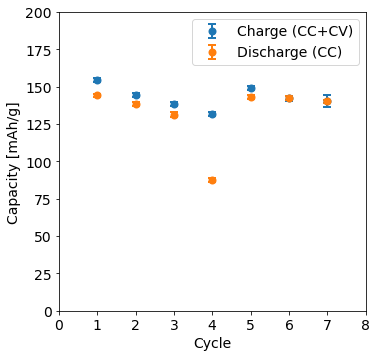

In [7]:
##### Set plot DataFrame
df_p = df_plot_rate

# Set x upper bound
upper = len(df_p.index)+1

# Create figure and axes
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(5.5, 5.5))

# Params
ax.set_ylim(ymin=0, ymax=200)
ax.set_xlim(xmin=0, xmax=upper)

y_values = ['p_cap_CC', 'p_cap_Tot', 'n_cap_CC']
yerr_values = ['p_std_CC', 'p_std_Tot', 'n_std_CC']

y_values = ['p_cap_Tot', 'n_cap_CC']
yerr_values = ['p_std_Tot', 'n_std_CC']

# Plot cycle data
for i, y in enumerate(y_values):
    print(i, '-->', y)
    for cell in names:
        x = df_p.index
        y = df_p.loc[idx[:],idx[cell, params[cell], y]]
        if avg[cell]:
            yerr_data = df_p.loc[idx[:],idx[cell, params[cell], yerr_values[i]]]
            plt.errorbar(x, y, yerr=yerr_data, fmt='o', capsize=4, elinewidth=2, markeredgewidth=2, label = names[cell] + '_' + y.name[2])    
        else:
            plt.scatter(x, y, label = names[cell] + '_' + y.name[2])
        
loc = plticker.MultipleLocator(base=1) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
    
plt.xlabel("Cycle")
plt.ylabel('Capacity '+gen_param_label(params[0]))

leg = plt.legend(loc='best')
leg.get_texts()[0].set_text('Charge (CC+CV)')
leg.get_texts()[1].set_text('Discharge (CC)')

plt.savefig(file_paths[cell].parent.joinpath('{}_{}.svg'.format('rate_cycles',names[cell])),
            format='svg', 
            dpi=600, 
            bbox_inches = 'tight')
plt.show()

0 --> p_cap_Tot
1 --> n_cap_CC


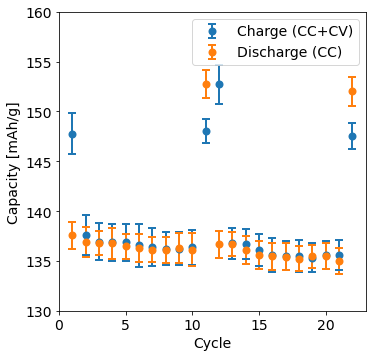

In [8]:
##### Set plot DataFrame
df_p = df_plot_deg

# Set x upper bound
upper = len(df_p.index)+1

# Create figure and axes
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(5.5, 5.5))

# Params
ax.set_ylim(ymin=130, ymax=160)
ax.set_xlim(xmin=0, xmax=upper)

y_values = ['p_cap_CC', 'p_cap_Tot', 'n_cap_CC']
yerr_values = ['p_std_CC', 'p_std_Tot', 'n_std_CC']

y_values = ['p_cap_Tot', 'n_cap_CC']
yerr_values = ['p_std_Tot', 'n_std_CC']

# Plot cycle data
for i, y in enumerate(y_values):
    print(i, '-->', y)
    for cell in names:
        x = df_p.index
        y = df_p.loc[idx[:],idx[cell, params[cell], y]]
        if avg[cell]:
            yerr_data = df_p.loc[idx[:],idx[cell, params[cell], yerr_values[i]]]
            plt.errorbar(x, y, yerr=yerr_data, fmt='o', capsize=4, elinewidth=2, markeredgewidth=2, label = names[cell] + '_' + y.name[2])    
        else:
            plt.scatter(x, y, label = names[cell] + '_' + y.name[2])
        
loc = plticker.MultipleLocator(base=5) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
    
plt.xlabel("Cycle")
plt.ylabel('Capacity '+gen_param_label(params[0]))

leg = plt.legend(loc='best')
leg.get_texts()[0].set_text('Charge (CC+CV)')
leg.get_texts()[1].set_text('Discharge (CC)')

plt.savefig(file_paths[cell].parent.joinpath('{}_{}.svg'.format('deg_cycles',names[cell])),
            format='svg', 
            dpi=600, 
            bbox_inches = 'tight')
plt.show()